In [1]:
%matplotlib inline

import pandas
import matplotlib.pyplot
import re
import sklearn.linear_model
import sklearn.grid_search
import math
import scipy.stats

In [2]:
train_df = pandas.DataFrame.from_csv("processed_data/training_data_raw.csv", index_col="id")
phase1_df = pandas.DataFrame.from_csv("processed_data/submission_data_raw.csv", index_col="id")
phase2_df = pandas.DataFrame.from_csv("processed_data/phase2_data_raw.csv", index_col="id")
# Drop worthless checkin data
worthless_re = re.compile(r"^checkin_info")
worthless_cols = [col for col in train_df.columns for m in [worthless_re.search(col)] if m]
train_df.drop(worthless_cols, inplace=True, axis="columns")
phase1_df.drop(worthless_cols, inplace=True, axis="columns")
phase2_df.drop(worthless_cols, inplace=True, axis="columns")
# Add a column that tells me whether or not this is the first measurement
first_ids = train_df.groupby("restaurant_id")["date"].nsmallest(1).reset_index("id")["id"]
first_inspections = train_df.index.isin(first_ids)
train_df["first"] = 0.
train_df.loc[first_inspections, "first"] = 1.
train_df.head(10)

,restaurant_id,date,*,**,***,last*,last**,last***,p*,p**,...,neighborhoods.South End,neighborhoods.Uphams Corner,neighborhoods.Waterfront,neighborhoods.West Roxbury,neighborhoods.West Roxbury Center,open,review_count,stars,zip,first
id,,,,,,,,,,,,,,,,,,,,,
28144,0ZED0WED,1190332800,3,1,0,0,0,0,0.000000,0.000000,...,1,1,1,1,1,1,66,3.5,2124,1
27691,0ZED0WED,1190937600,3,1,0,3,1,0,3.000000,1.000000,...,1,1,1,1,1,1,66,3.5,2124,0
24765,0ZED0WED,1206489600,3,1,0,3,1,0,3.000000,1.000000,...,1,1,1,1,1,1,66,3.5,2124,0
31333,0ZED0WED,1207094400,3,1,0,3,1,0,3.000000,1.000000,...,1,1,1,1,1,1,66,3.5,2124,0
25193,0ZED0WED,1223424000,6,2,4,3,1,0,3.000000,1.000000,...,1,1,1,1,1,1,66,3.5,2124,0
14328,0ZED0WED,1224028800,6,2,4,6,2,4,4.540390,1.513463,...,1,1,1,1,1,1,66,3.5,2124,0
12775,0ZED0WED,1236038400,3,0,0,6,2,4,5.048200,1.682733,...,1,1,1,1,1,1,66,3.5,2124,0
25850,0ZED0WED,1248307200,1,0,2,3,0,0,4.173916,0.964450,...,1,1,1,1,1,1,66,3.5,2124,0
17443,0ZED0WED,1259712000,3,1,1,1,0,2,2.645459,0.500002,...,1,1,1,1,1,1,66,3.5,2124,0


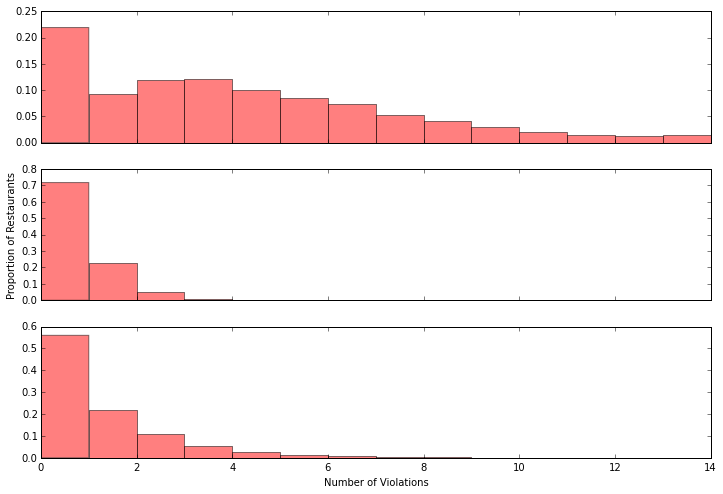

In [3]:
fig1, axs1 = matplotlib.pyplot.subplots(3, sharex=True)
fig1.set_size_inches(12, 8)

for i, label in enumerate(['*', '**', '***']):
    train_data = train_df.reset_index()[label]
    axs1[i].hist(train_data, normed=True, bins=range(0, 15), facecolor='red', alpha=0.5)
    
axs1[2].set_xlabel("Number of Violations")
axs1[1].set_ylabel("Proportion of Restaurants")

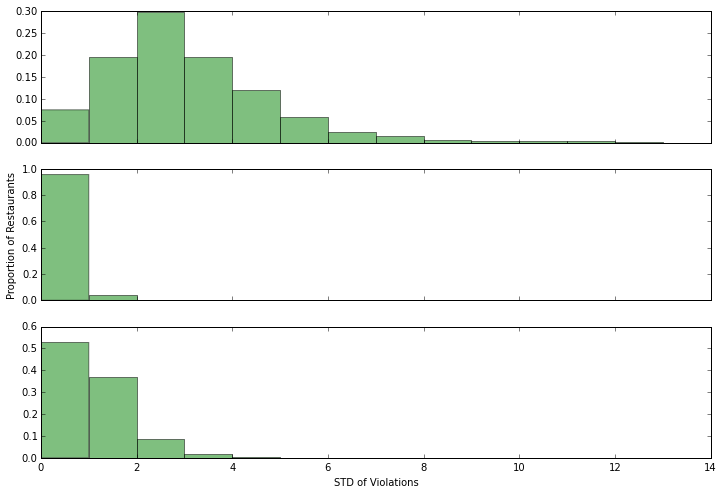

In [4]:
fig2, axs2 = matplotlib.pyplot.subplots(3, sharex=True)
fig2.set_size_inches(12, 8)

for i, label in enumerate(['*', '**', '***']):
    train_data = train_df.reset_index().groupby("restaurant_id")[label].std()
    axs2[i].hist(train_data, normed=True, bins=range(0, 15), facecolor='green', alpha=0.5)

axs2[2].set_xlabel("STD of Violations")
axs2[1].set_ylabel("Proportion of Restaurants")

In [5]:
singlets = train_df["restaurant_id"].isin(train_df.groupby("restaurant_id").count().query("date == 1").index)
doublets = train_df["restaurant_id"].isin(train_df.groupby("restaurant_id").count().query("date == 2").index)
singles_df = train_df[(doublets | singlets | first_inspections)]
non_singles_df = train_df[~(doublets | singlets | first_inspections)]

print(non_singles_df["restaurant_id"])

id
27691    0ZED0WED
24765    0ZED0WED
31333    0ZED0WED
25193    0ZED0WED
14328    0ZED0WED
12775    0ZED0WED
25850    0ZED0WED
17443    0ZED0WED
5576     0ZED0WED
4180     0ZED0WED
33309    0ZED0WED
3527     0ZED0WED
22246    0ZED0WED
17990    0ZED0WED
1601     0ZED0WED
...
26392    ydEjx9oW
31085    ydEjx9oW
23210    ydEjz7EW
23077    ydEjz7EW
8107     ydEjz7EW
5888     ydEjz7EW
9063     ydEjz7EW
24540    ydEjz7EW
3409     ydEjz7EW
29116    ydEjz7EW
9652     ydEjz7EW
3501     ydEjz7EW
31777    ydEjz7EW
21278    ydEjz7EW
11991    ydEjz7EW
Name: restaurant_id, Length: 25189, dtype: object


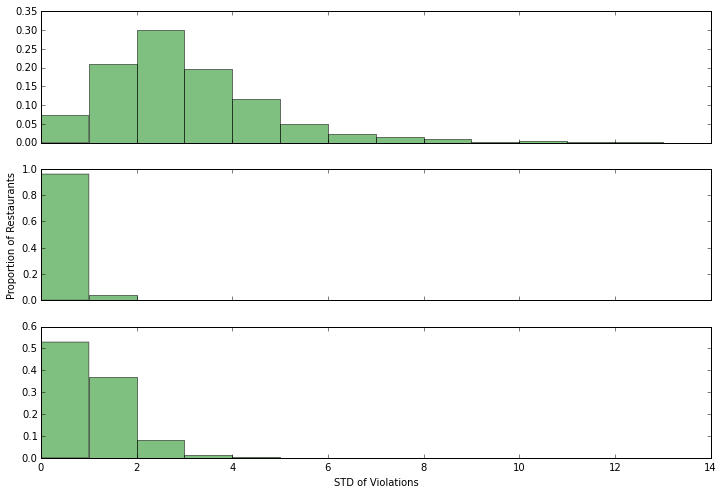

In [6]:
fig3, axs3 = matplotlib.pyplot.subplots(3, sharex=True)
fig3.set_size_inches(12, 8)

for i, label in enumerate(['*', '**', '***']):
    train_data = non_singles_df.reset_index().groupby("restaurant_id")[label].std()
    axs3[i].hist(train_data, normed=True, bins=range(0, 15), facecolor='green', alpha=0.5)

axs3[2].set_xlabel("STD of Violations")
axs3[1].set_ylabel("Proportion of Restaurants")

In [104]:
def rmsle(p, y):
    log_pred = p.apply(lambda x: math.log(x + 1))
    log_true = y.apply(lambda x: math.log(x + 1))
    s = math.sqrt(1/y.shape[0] * (log_pred - log_true).pow(2).sum())
    return s

def rmsle_w(p, y, weights=[1, 3, 5]):
    log_sum = 0
    for i in range(0, y.shape[1]):
        log_pred = p.iloc[:, i].apply(lambda x: math.log(weights[i] * x + 1))
        log_true = y.iloc[:, i].apply(lambda x: math.log(weights[i] * x + 1))
        log_sum += (log_pred - log_true).pow(2).sum()
    s = math.sqrt(1/y.shape[0] * log_sum)
    return s


def rmsle_score(estimator, X, y):
    return rmsle_w(pandas.Series(estimator.predict(X), index=y.index).clip_lower(0), y)

In [94]:
# For non-singlets/doublets, predict based on previous violation data
non_singles_predict_cols = ["p*", "p**", "p***", "last*", "last**", "last***", "std*", "std**", "std***"]
regressor = sklearn.linear_model.ElasticNet(normalize=True, precompute=True)
grid_vars = {}
    #"alpha": scipy.stats.uniform(loc=0, scale=1),
    #        "l1_ratio": scipy.stats.uniform()}

best_non_singles_regressors = []
for label in ['*', '**', '***']:
    search = sklearn.grid_search.RandomizedSearchCV(sklearn.linear_model.Lars(normalize=True),
                                                    param_distributions=grid_vars,
                                                    n_iter=1,
                                                    scoring=rmsle_score,
                                                    cv=3,
                                                    verbose=1,
                                                    refit=True)
    search.fit(non_singles_df[non_singles_predict_cols], non_singles_df[label])
    print("Best parameters:")
    print(search.best_params_)
    print("Best score:")
    print(search.best_score_)
    print("Best coefficients:")
    print(search.best_estimator_.coef_)
    best_non_singles_regressors = best_non_singles_regressors + [search.best_estimator_]


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters:

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished



{}
Best score:
0.8114735448442372
Best coefficients:
[ 0.04891926  0.08302571 -0.08619595  0.42074507 -0.13319006 -0.00280036
  0.07023233  0.21090563 -0.04443548]
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters:

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished



{}
Best score:
0.3351738742292593
Best coefficients:
[ 0.00916379 -0.05428548 -0.00758625 -0.00667251  0.4666648   0.00128567
  0.00509124  0.09941303 -0.00694422]
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters:
{}
Best score:
0.5420488731448305
Best coefficients:
[ 0.011346    0.03480476 -0.02013539 -0.01573201 -0.06444583  0.45701772
 -0.00543625 -0.0036254   0.0518679 ]


In [95]:
# For singlets/doublets, predict based on everything else!
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numeric_train_df = singles_df.select_dtypes(include=numerics).copy()
numeric_train_df.drop(non_singles_predict_cols, inplace=True, axis="columns")
regressor = sklearn.linear_model.ElasticNet(normalize=True)
grid_vars = {}
    #"alpha": scipy.stats.uniform(loc=0, scale=10),
    #        "l1_ratio": scipy.stats.uniform()}

best_singles_regressors = []
for label in ['*', '**', '***']:
    search = sklearn.grid_search.RandomizedSearchCV(sklearn.linear_model.Lars(normalize=True),
                                                    param_distributions=grid_vars,
                                                    n_iter=1,
                                                    scoring=rmsle_score,
                                                    cv=10,
                                                    verbose=1,
                                                    refit=True)
    search.fit(numeric_train_df.drop(["*", "**", "***"], axis="columns"), numeric_train_df[label])
    print("Best parameters:")
    print(search.best_params_)
    print("Best score:")
    print(search.best_score_)
    best_singles_regressors = best_singles_regressors + [search.best_estimator_]

/home/paste/.local/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 83 iterations, i.e. alpha=4.017e-06, with an active set of 82 regressors, and the smallest cholesky pivot element being 5.373e-08
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
/home/paste/.local/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 83 iterations, i.e. alpha=2.027e-05, with an active set of 81 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
/home/paste/.local/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 84 iterations, i.e. alpha=1.561e-06, with an active set of 82 regressors, and the smallest cholesky pivot element be

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters:

/home/paste/.local/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 83 iterations, i.e. alpha=7.649e-06, with an active set of 82 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
/home/paste/.local/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 74 iterations, i.e. alpha=4.999e-05, with an active set of 71 regressors, and the smallest cholesky pivot element being 4.215e-08
  ConvergenceWarning)
/home/paste/.local/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 81 iterations, i.e. alpha=3.371e-05, with an active set of 77 regressors, and the smallest cholesky pivot e


{}
Best score:
0.983327179845748
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters:

/home/paste/.local/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 78 iterations, i.e. alpha=2.018e-05, with an active set of 77 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
/home/paste/.local/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 82 iterations, i.e. alpha=9.057e-06, with an active set of 81 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
/home/paste/.local/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 83 iterations, i.e. alpha=2.741e-06, with an active set of 82 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Don


{}
Best score:
0.38834369111633393
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters:
{}
Best score:
0.641975088923309


/home/paste/.local/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 57 iterations, i.e. alpha=1.708e-04, with an active set of 57 regressors, and the smallest cholesky pivot element being 3.332e-08
  ConvergenceWarning)
/home/paste/.local/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 58 iterations, i.e. alpha=1.541e-04, with an active set of 58 regressors, and the smallest cholesky pivot element being 3.332e-08
  ConvergenceWarning)
/home/paste/.local/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 70 iterations, i.e. alpha=7.591e-05, with an active set of 68 regressors, and the smallest cholesky pivot element being 3.332e-08
  ConvergenceWarning)
/home/paste/.local/lib/py

In [110]:
# Put everything together
prediction = pandas.DataFrame(index=train_df.index)
prediction["restaurant_id"] = train_df["restaurant_id"]
for n, label in enumerate(["*", "**", "***"]):
    prediction.loc[non_singles_df.index, label] = best_non_singles_regressors[n].predict(non_singles_df[non_singles_predict_cols]).round()
    prediction.loc[singles_df.index, label] = best_singles_regressors[n].predict(numeric_train_df.drop(["*", "**", "***"], axis="columns")).round()
    
prediction = prediction.clip_lower(0)
print(prediction.loc[:, ["*", "**", "***"]])
print(rmsle_w(prediction.loc[:, ["*", "**", "***"]], train_df.loc[:, ["*", "**", "***"]]))

        *  **  ***
id                
28144   6   1    1
27691   4   1    0
24765   3   1    0
31333   3   1    0
25193   3   1    0
14328   5   1    2
12775   5   1    2
25850   4   0    1
17443   3   0    2
5576    4   1    1
4180    4   1    1
33309   7   1    1
3527    7   1    1
22246  10   2    3
17990   3   0    1
1601    4   0    1
20355   4   0    1
1028    4   0    1
14085   3   0    1
4772    4   0    1
17230   4   1    1
19976   4   1    1
8566    5   1    1
27872   4   1    1
10757   3   1    1
32641   2   0    1
7601    3   0    1
500     2   0    1
10435   2   0    1
6187    2   0    1
...    ..  ..  ...
2938    3   0    0
17434   2   0    1
6702    2   0    1
16639   2   0    1
16781   2   0    1
10410   2   0    1
10901   2   0    1
6928    2   0    1
5738    2   0    1
25560   2   0    1
6433    2   0    1
12800   2   0    1
15819   2   0    1
32107   2   0    1
26392   2   0    1
31085   2   0    1
6878    7   1    1
23210  10   0    0
23077   6   0    1
8107    4   

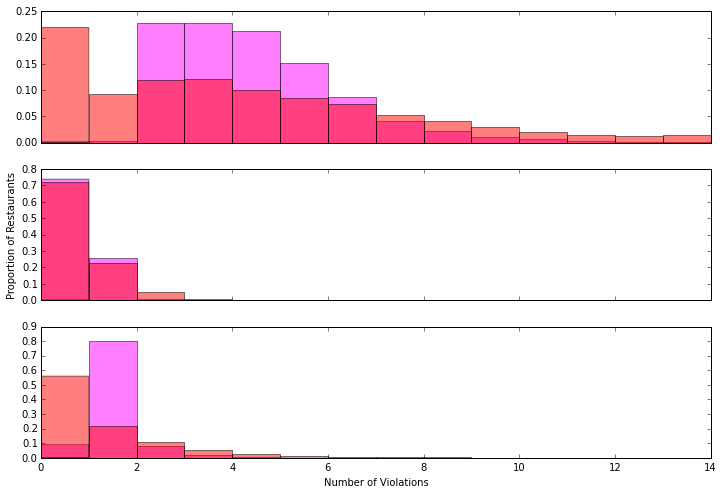

In [111]:
fig4, axs4 = matplotlib.pyplot.subplots(3, sharex=True)
fig4.set_size_inches(12, 8)

for i, label in enumerate(['*', '**', '***']):
    train_data = prediction.reset_index()[label]
    real_data = train_df.reset_index()[label]
    axs4[i].hist(train_data, normed=True, bins=range(0, 15), facecolor='magenta', alpha=0.5)
    axs4[i].hist(real_data, normed=True, bins=range(0, 15), facecolor='red', alpha=0.5)
    
axs4[2].set_xlabel("Number of Violations")
axs4[1].set_ylabel("Proportion of Restaurants")

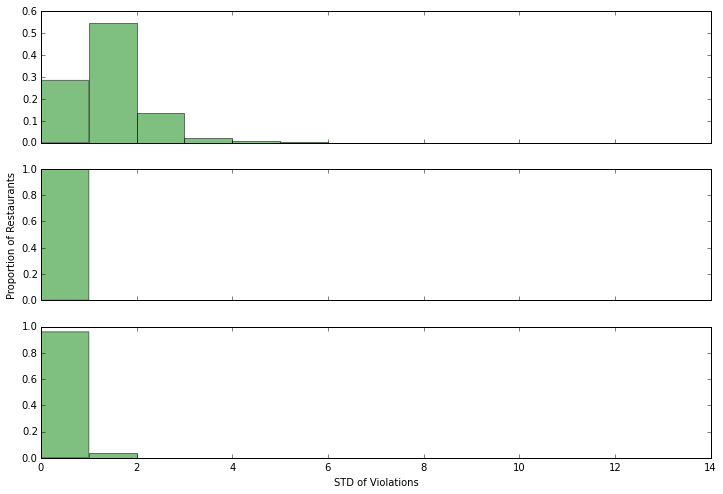

In [112]:
fig5, axs5 = matplotlib.pyplot.subplots(3, sharex=True)
fig5.set_size_inches(12, 8)

for i, label in enumerate(['*', '**', '***']):
    train_data = prediction.reset_index().groupby("restaurant_id")[label].std()
    axs5[i].hist(train_data, normed=True, bins=range(0, 15), facecolor='green', alpha=0.5)

axs5[2].set_xlabel("STD of Violations")
axs5[1].set_ylabel("Proportion of Restaurants")